# Trabajo práctico 2

**Nombre**: Cristina Arroyo Huerta

* Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
    


1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

In [1]:
import cv2 as cv
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
def create_gauss_filter(h, w, k_size, sigma):
    """
    Crea un filtro gaussiano en el dominio espacial y su transformada de Fourier.

    Parámetros:
    - h: Altura del filtro
    - w: Ancho del filtro
    - k_size: Tamaño del kernel gaussiano
    - sigma: Desviación estándar del kernel gaussiano

    Retorna:
    - gauss_filter: Filtro gaussiano en el dominio espacial
    - gauss_filter_fft: Transformada de Fourier del filtro gaussiano
    """
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - (k_size-1)/2)**2 + (y - (k_size-1)/2)**2) / (2 * sigma**2)),
        (k_size, k_size)
    )

    kernel = kernel / np.sum(kernel)

    filtro_espacial = np.zeros((h, w))
    filtro_espacial[(h-k_size)//2:(h+k_size)//2, (w-k_size)//2:(w+k_size)//2] = kernel

    gauss_filter = np.roll(filtro_espacial, shift=(-h//2, -w//2), axis=(0, 1))
    gauss_filter_fft = fft2(gauss_filter)

    return gauss_filter, gauss_filter_fft



In [3]:
def apply_filter(imagen, gauss_filter_fft):

    # Calcular la transformada de Fourier de la imagen
    imagen_fft = fft2(imagen)

    # Aplicar el filtro gaussiano en el dominio de la frecuencia
    imagen_blurred_fft = imagen_fft * gauss_filter_fft

    # Calcular la inversa de la transformada de Fourier para obtener la imagen con desenfoque
    imagen_blurred = np.abs(ifft2(imagen_blurred_fft))

    return imagen_blurred


In [4]:
def fft2_mod(image):
  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


In [5]:
def plot_filter_and_fft(gauss_filter, fft_gauss_filter, k_size, sigma):
    # Crear figuras
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotear el filtro gaussiano en el dominio espacial
    axs[0].imshow(fft2_mod(gauss_filter.astype(np.float32)), cmap='jet')
    axs[0].set_title(f'Filtro Gaussiano (Kernel={k_size}, Sigma={sigma})')

    # Plotear la transformada de Fourier del filtro gaussiano
    axs[1].imshow(fft2_mod(fft_gauss_filter), cmap='jet')
    axs[1].set_title('Transformada de Fourier')

    plt.show()

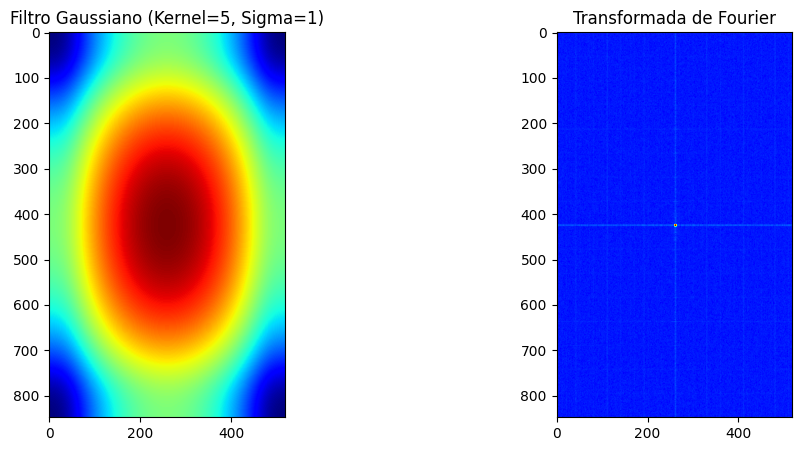

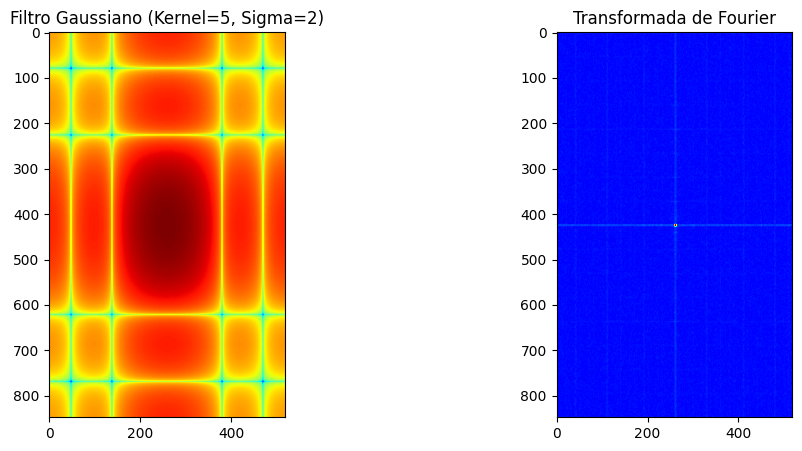

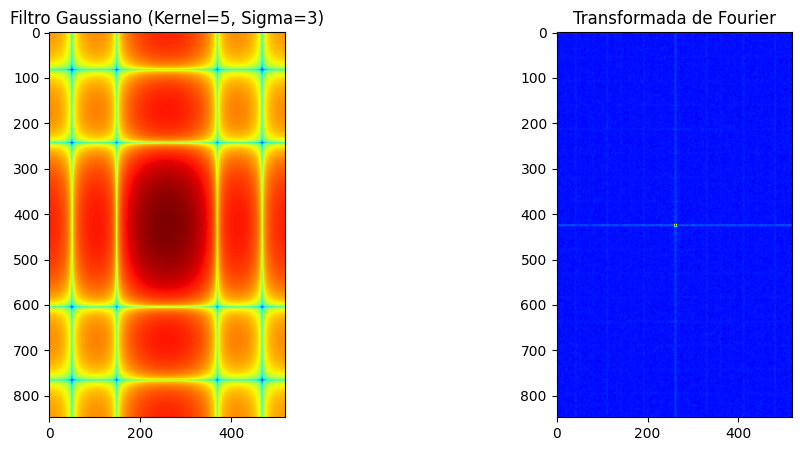

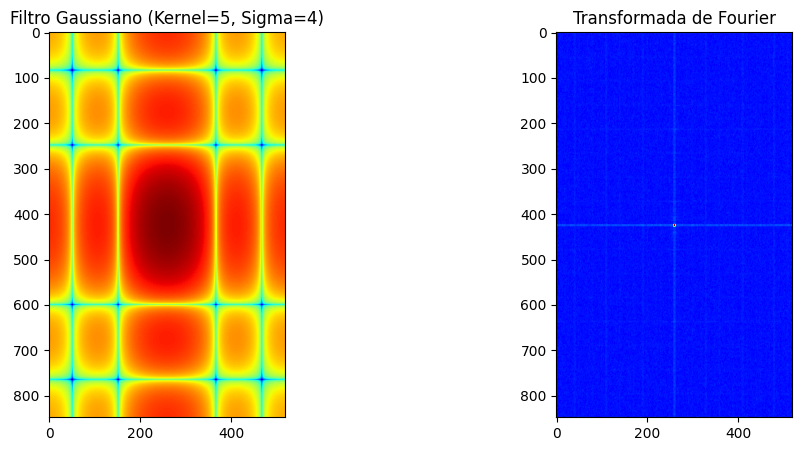

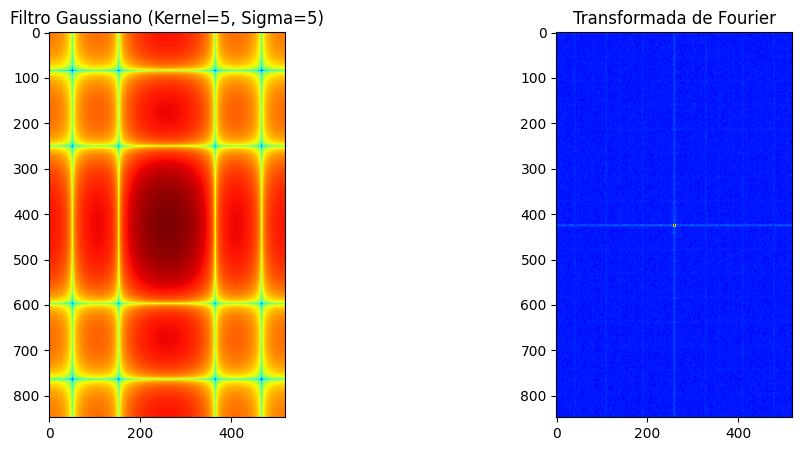

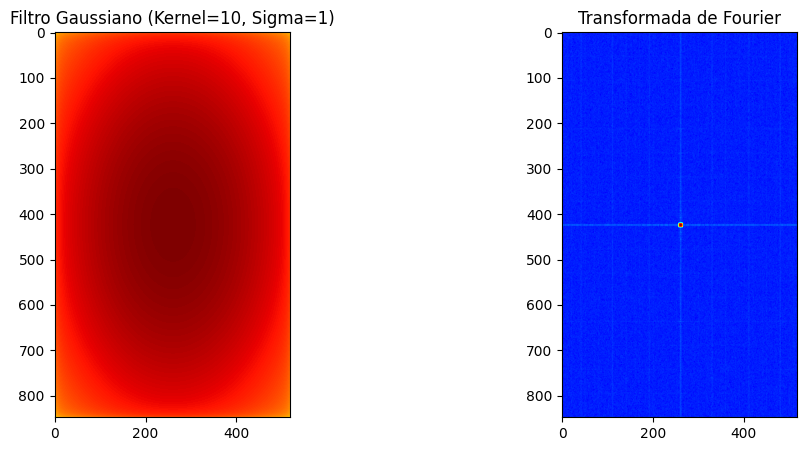

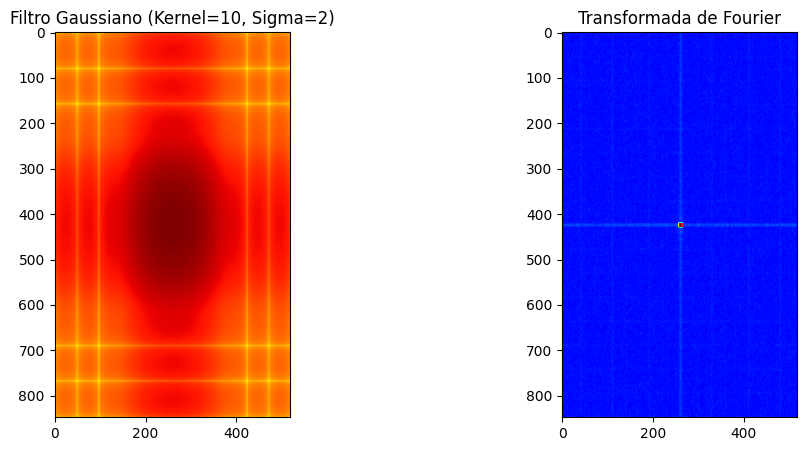

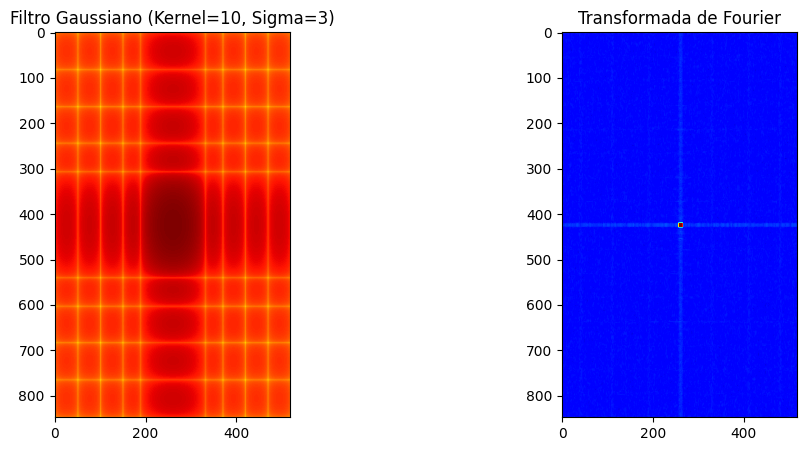

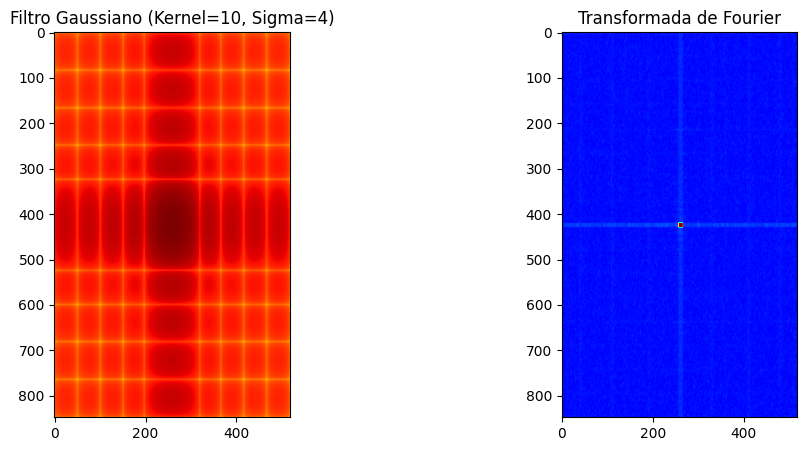

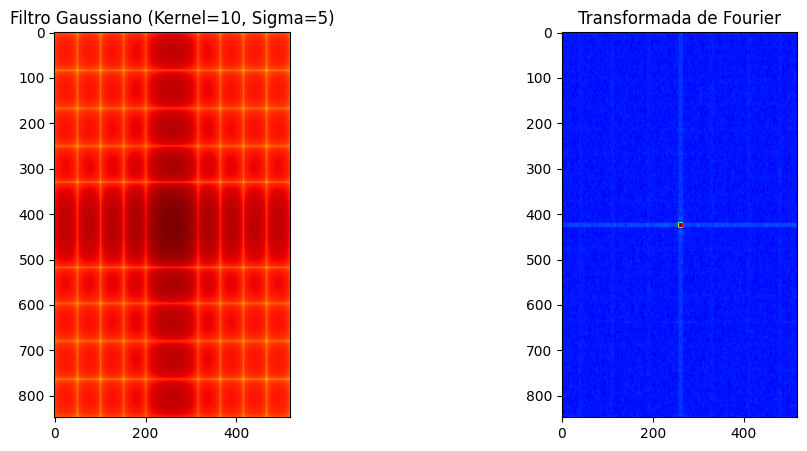

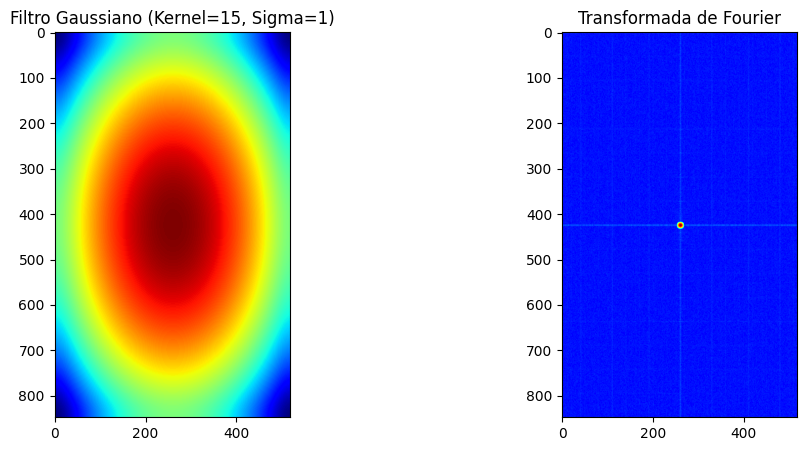

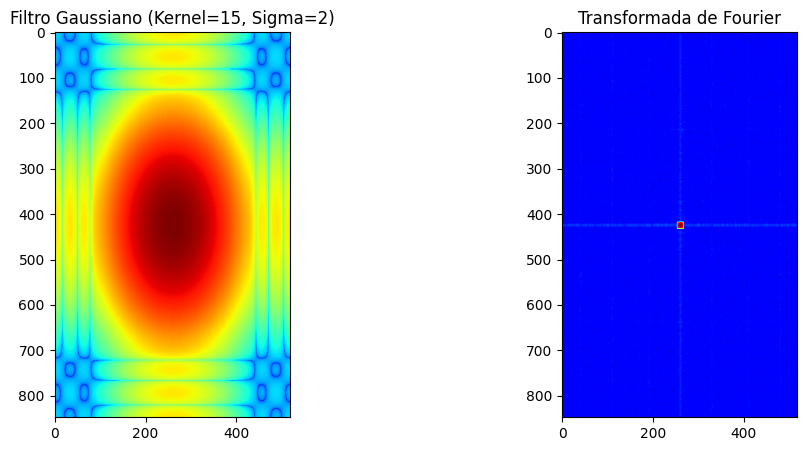

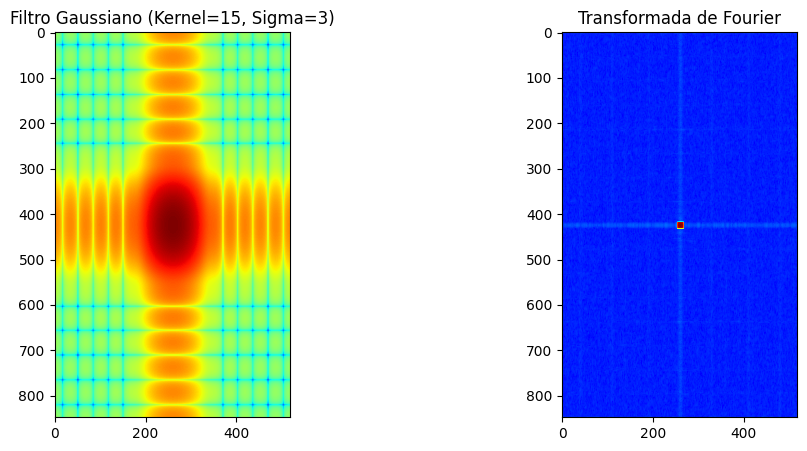

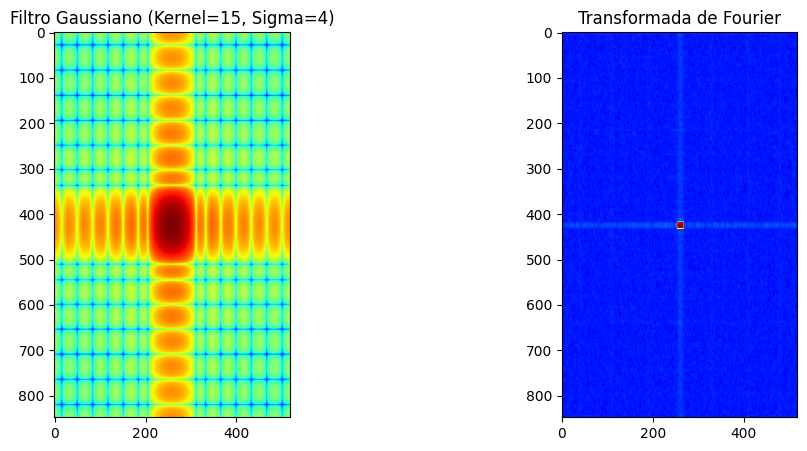

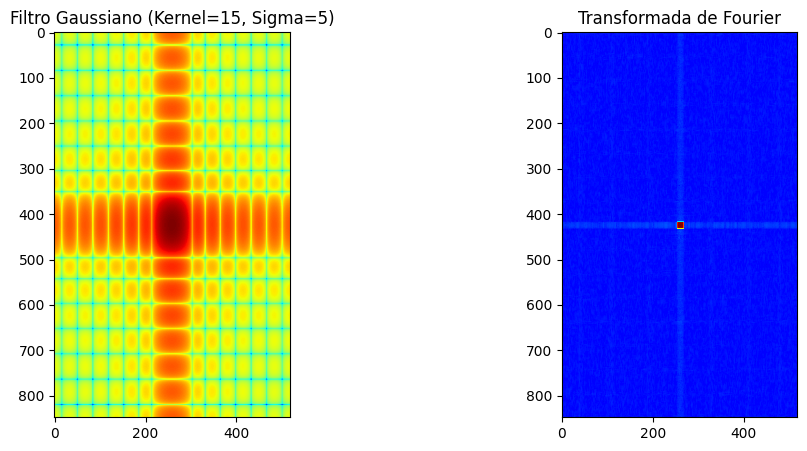

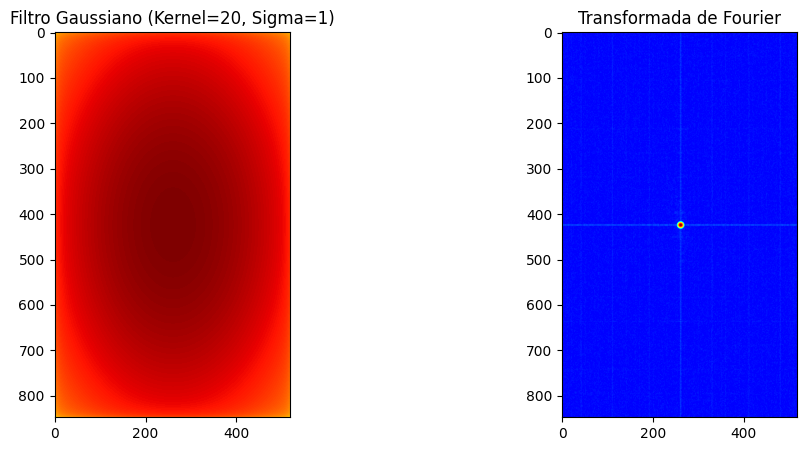

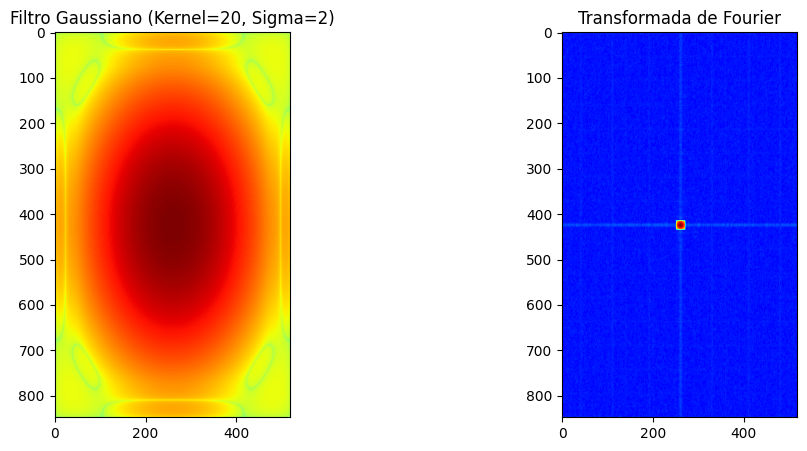

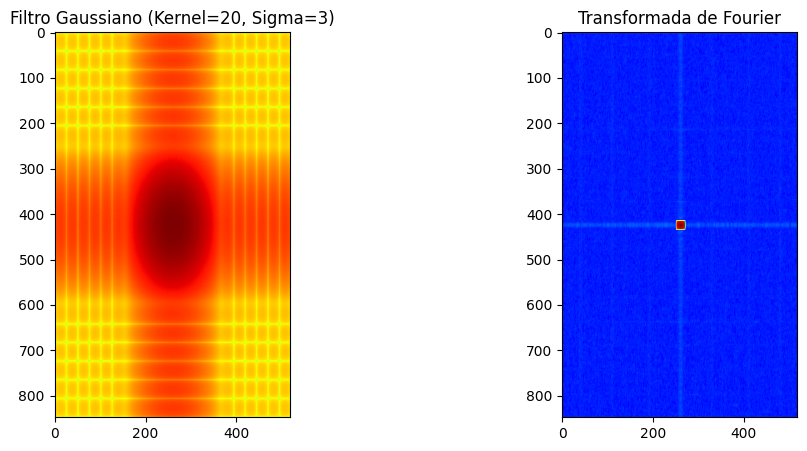

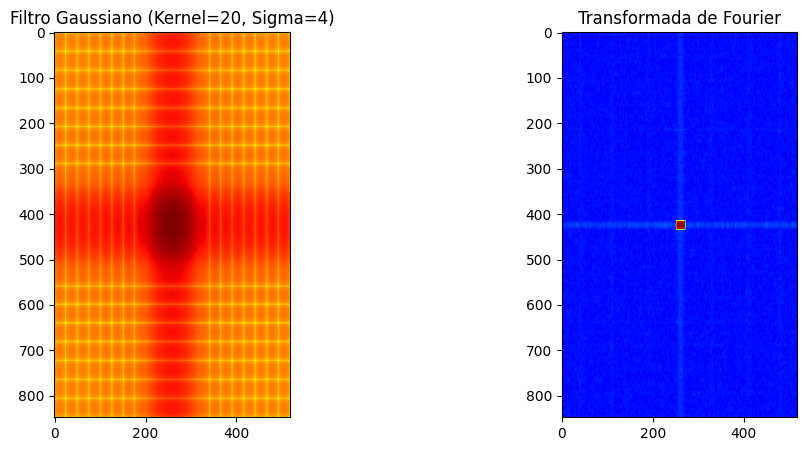

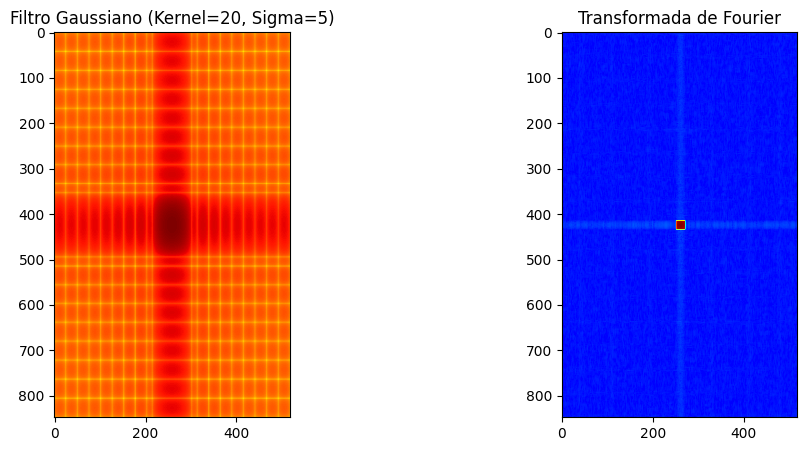

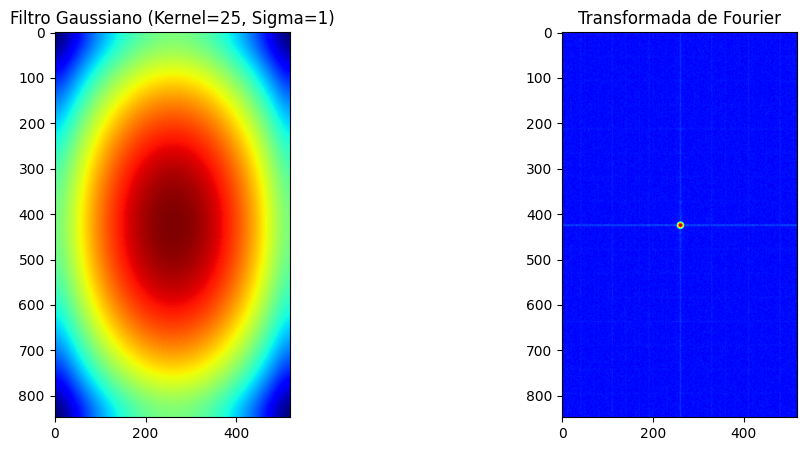

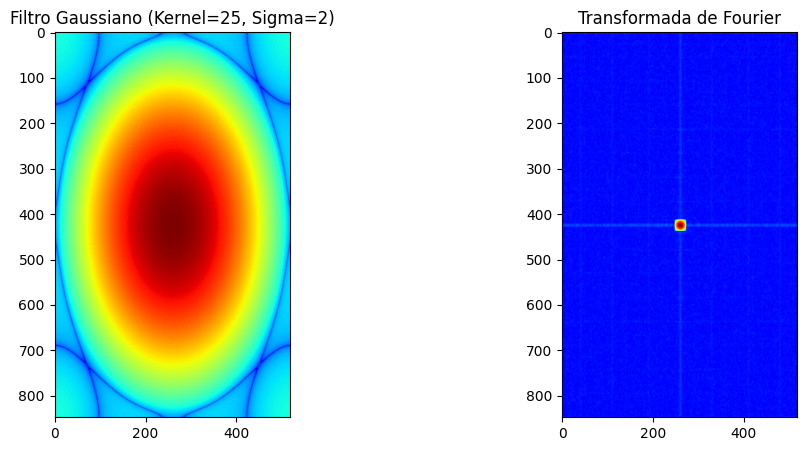

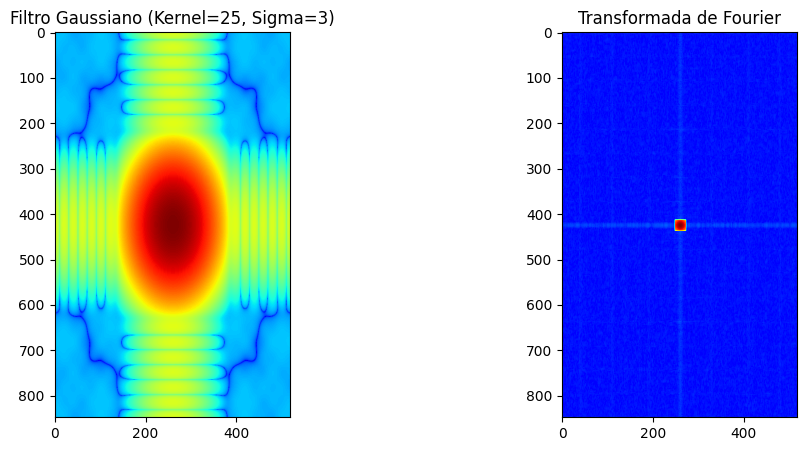

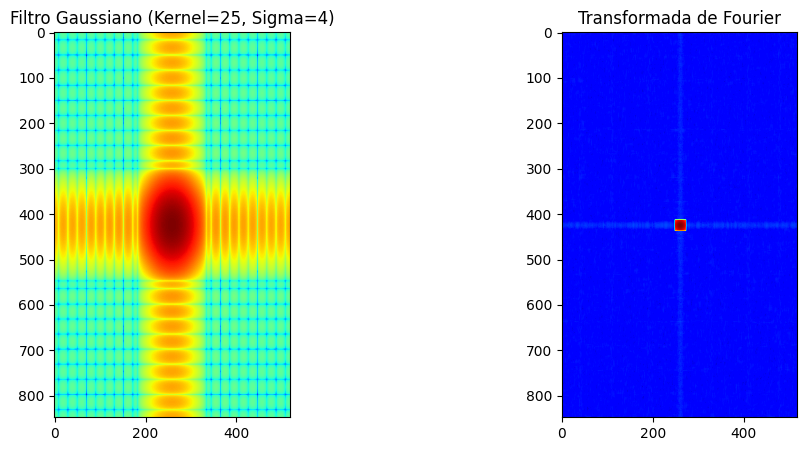

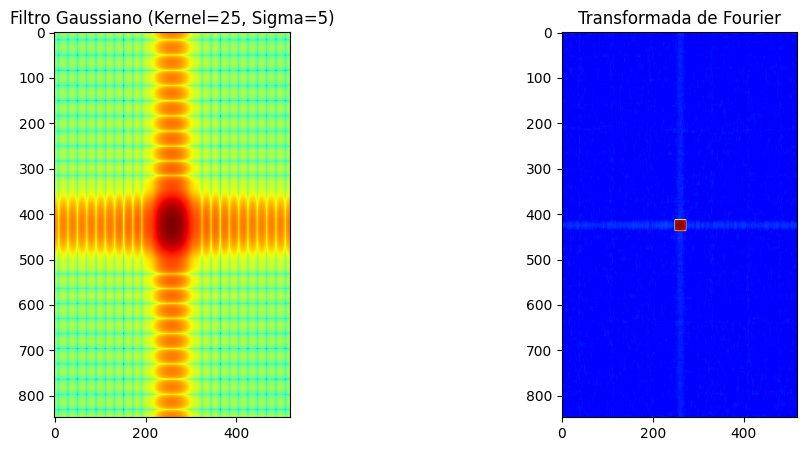

In [6]:
imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
altura = imagen.shape[0]
ancho = imagen.shape[1]
h, w = altura, ancho
k_sizes = [5, 10, 15, 20, 25]  # Tamaños de kernel
sigmas = [1, 2, 3, 4, 5]  # Valores de sigma

# Crear y graficar los filtros gaussiano y su transformada de Fourier
for k_size in k_sizes:
    for sigma in sigmas:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
        plot_filter_and_fft(gauss_filter, fft_gauss_filter, k_size, sigma)

In [7]:
def plot_original_and_filtered(image_path, k_size, sigma):
    imagen = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
    imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    
    # Crear figuras
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Mostrar la imagen original en escala de grises
    axs[0].imshow(imagen, cmap='gray')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')
    # Mostrar la imagen con desenfoque despues de aplicar el filtro
    axs[1].imshow(imagen_blurred, cmap='gray')
    axs[1].set_title(f'Imagen con desenfoque (Kernel={k_size}, Sigma={sigma})')
    axs[1].axis('off')
    plt.show()

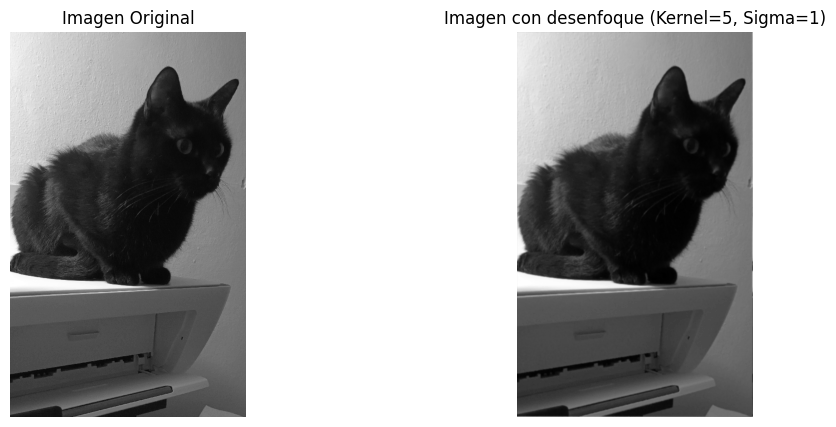

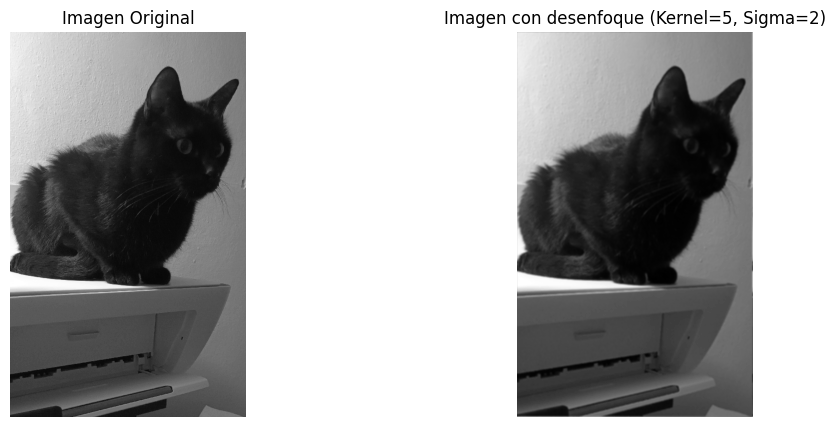

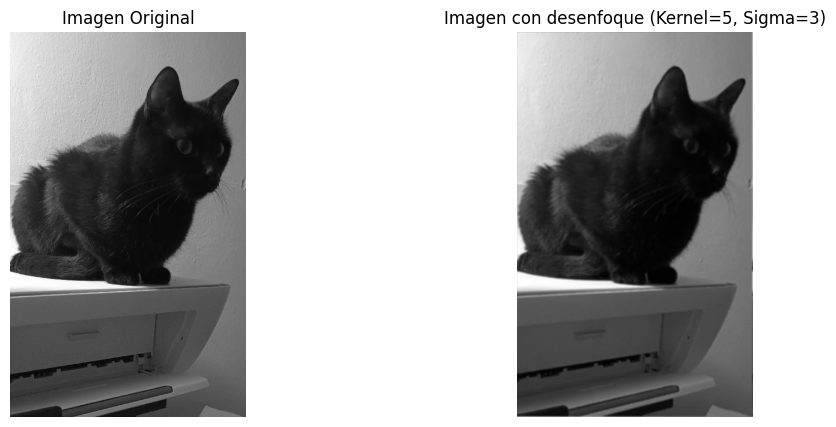

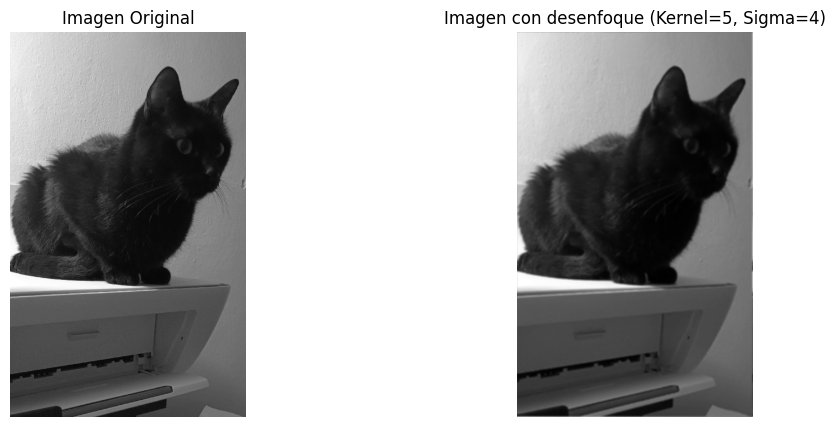

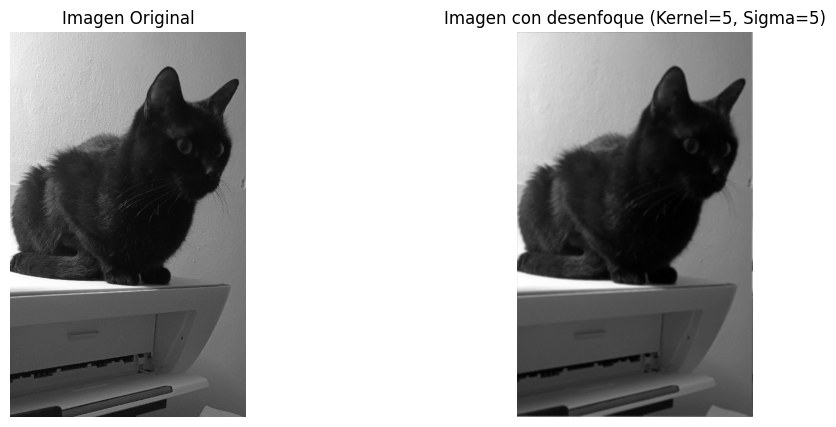

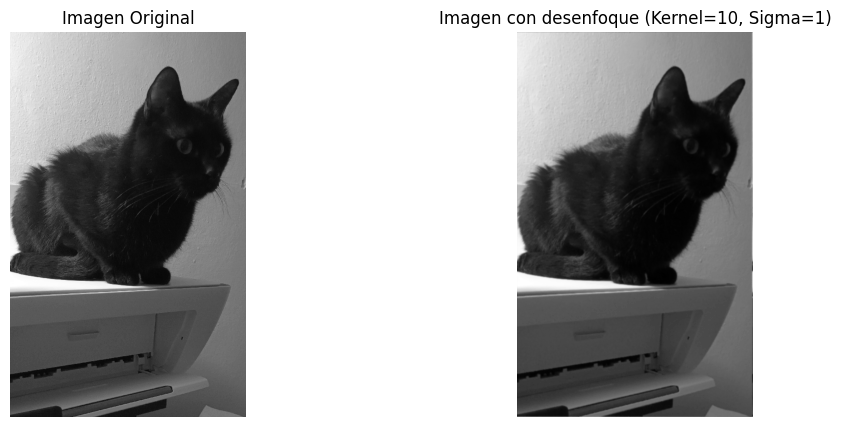

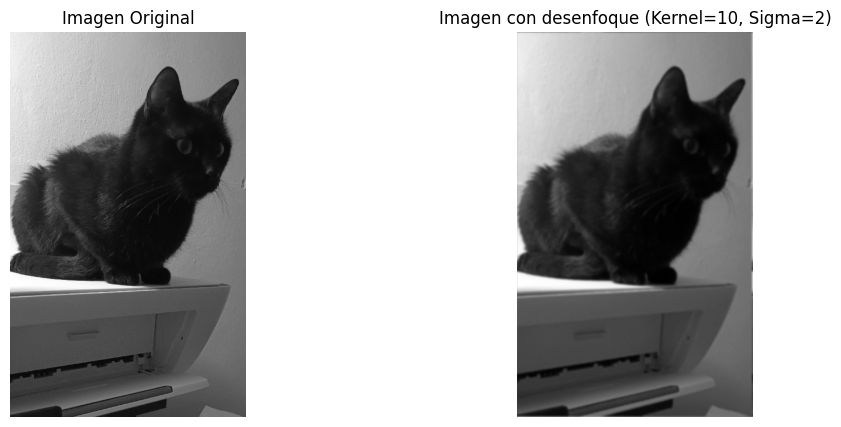

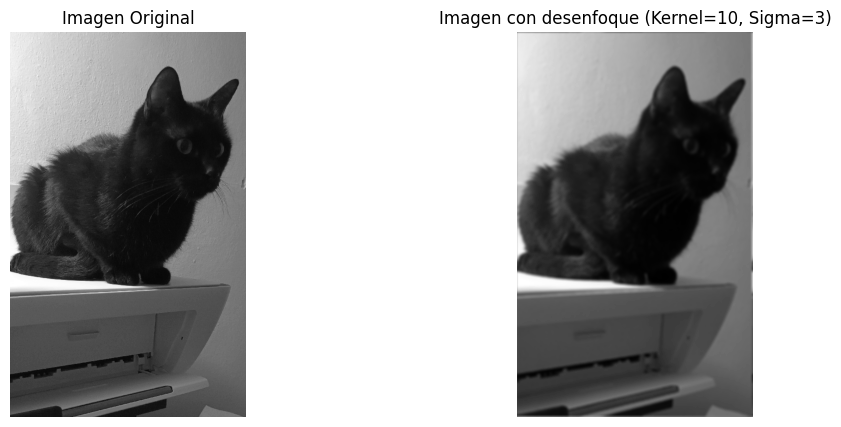

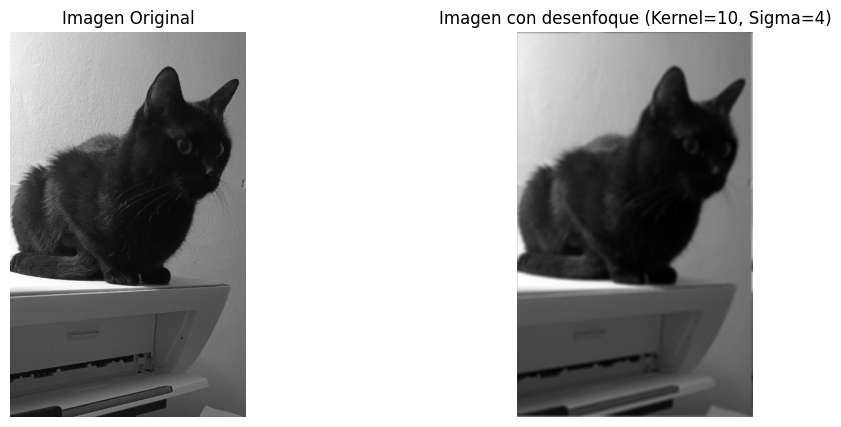

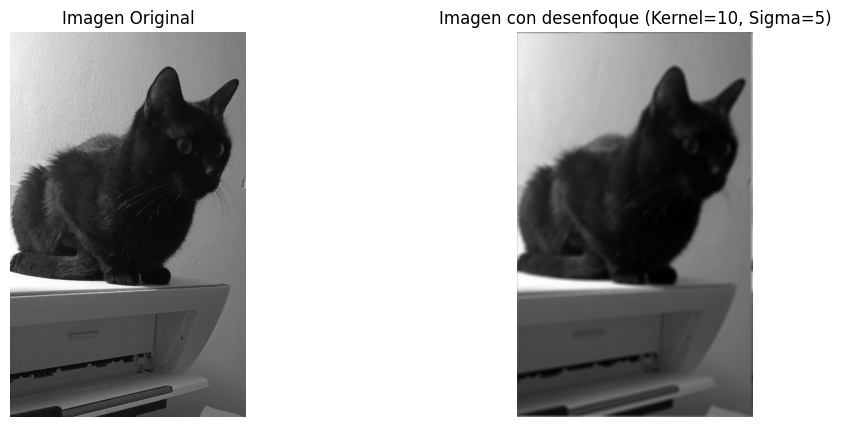

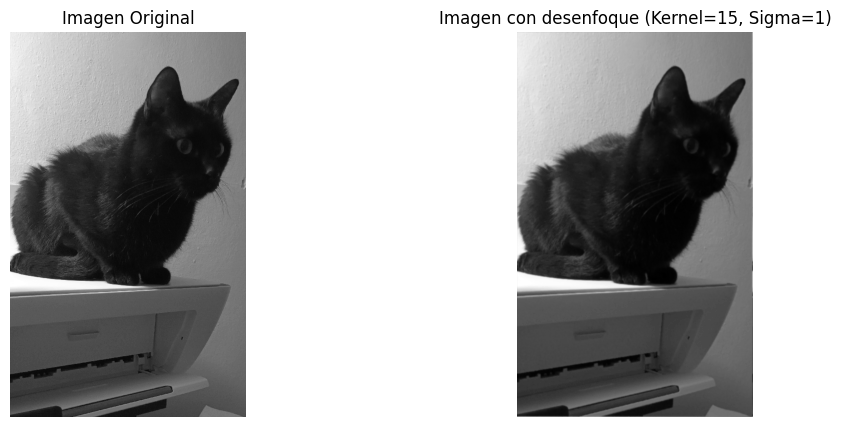

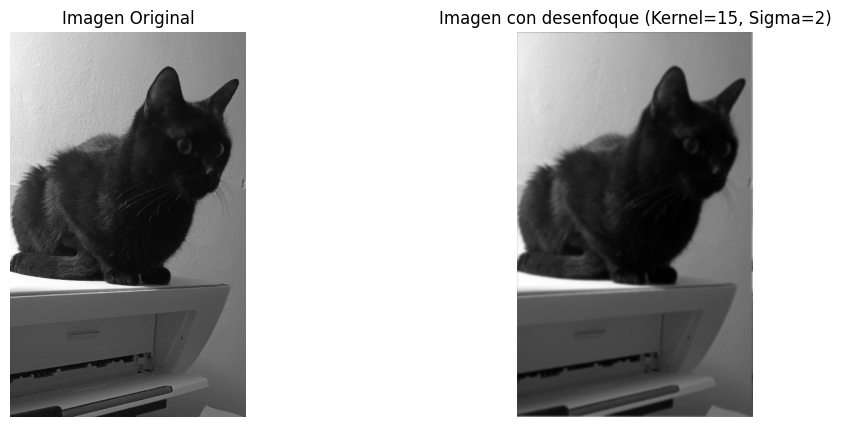

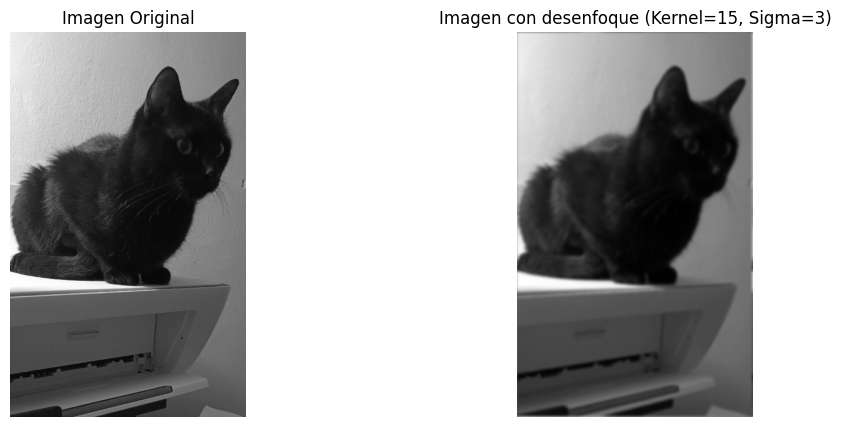

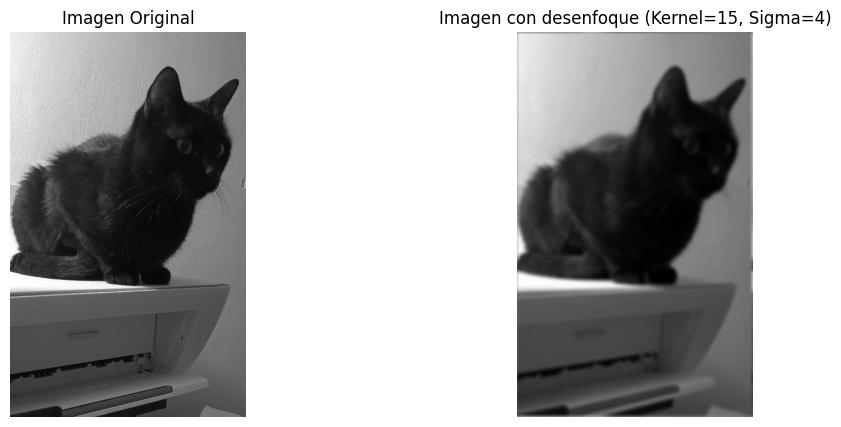

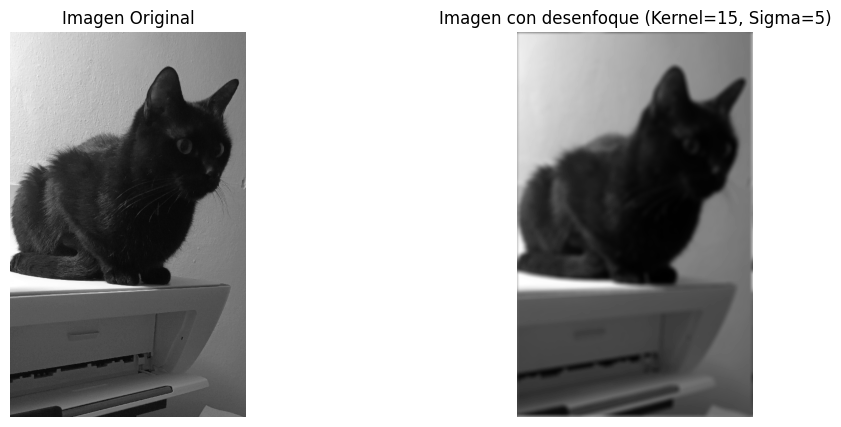

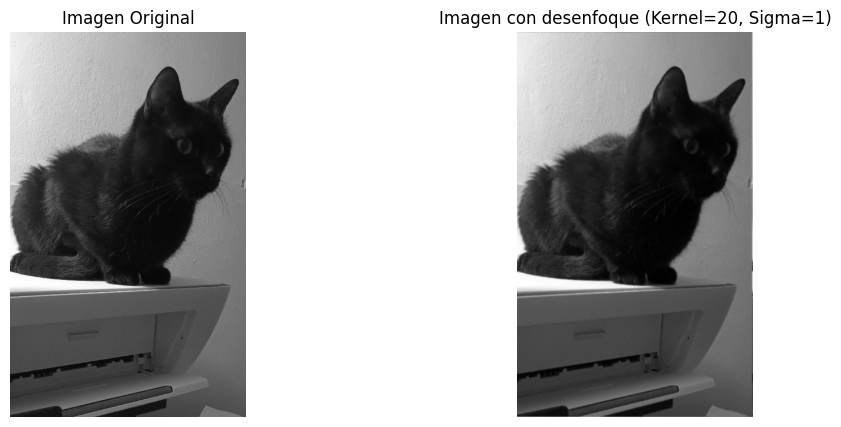

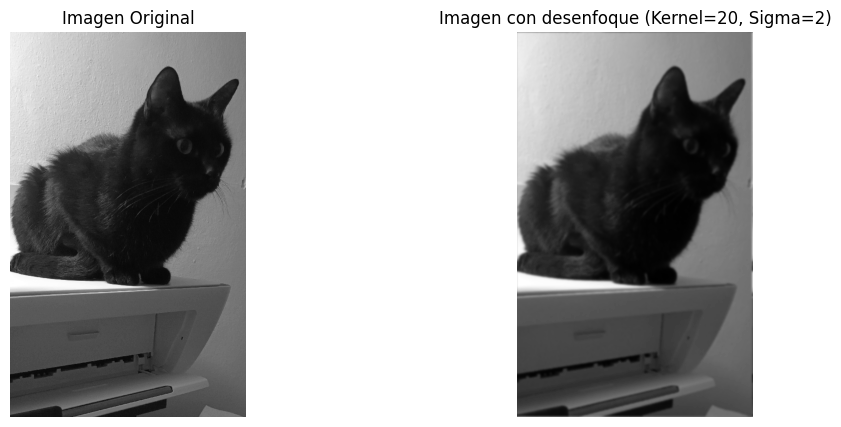

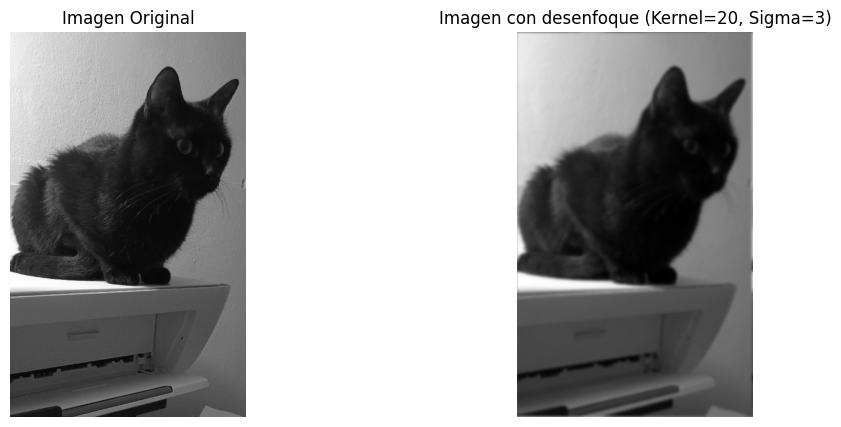

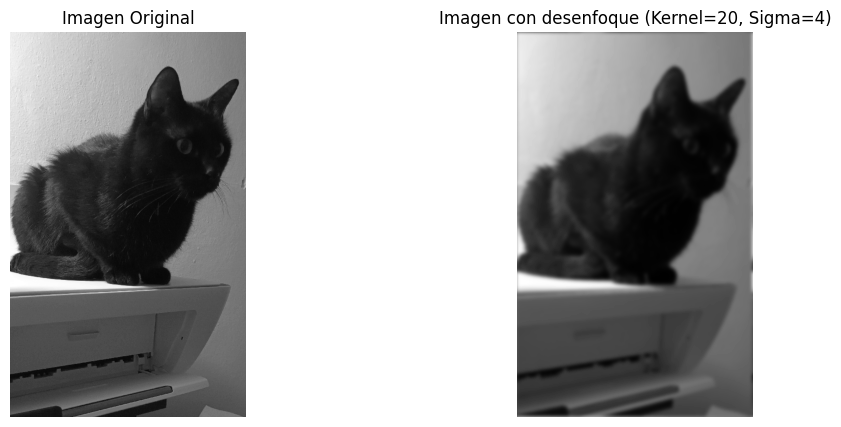

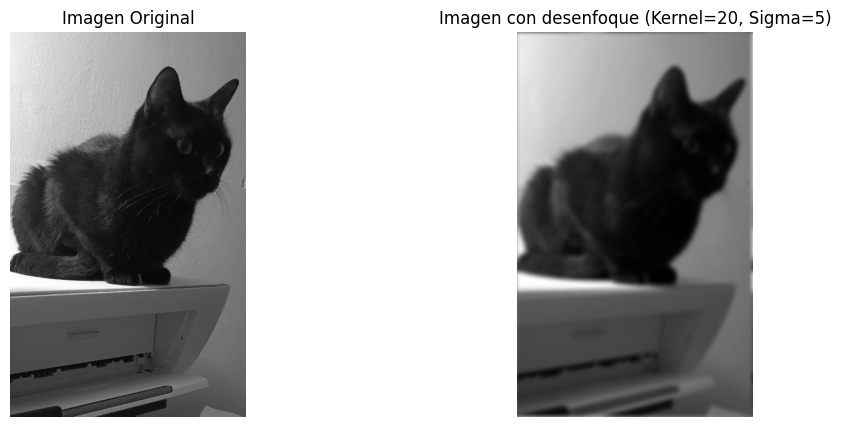

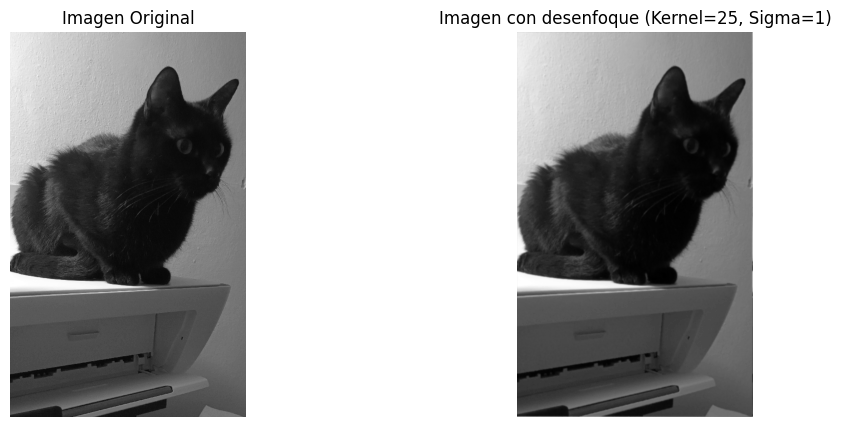

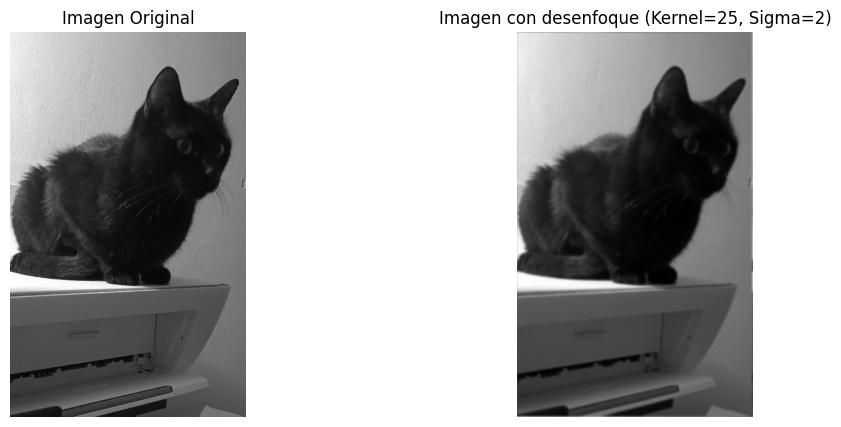

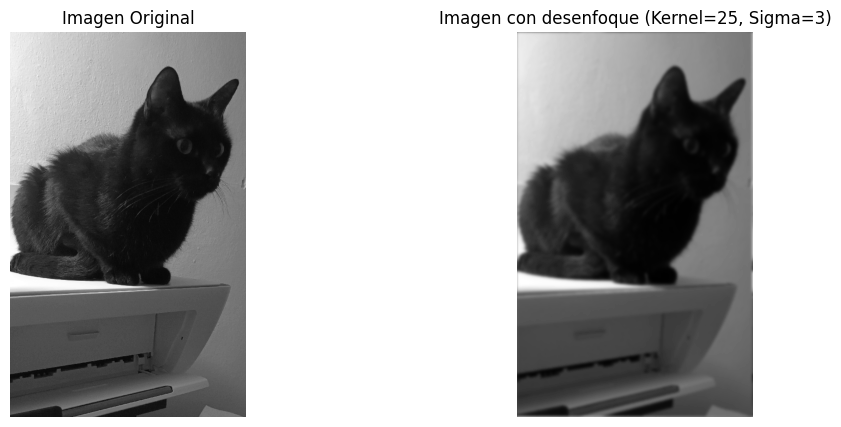

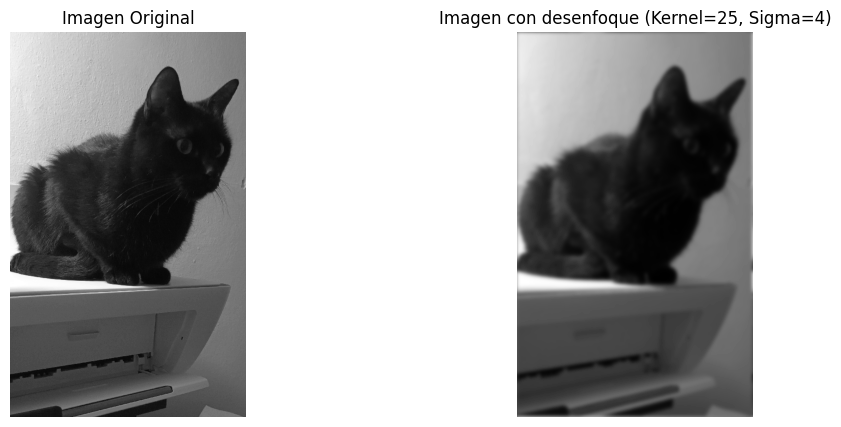

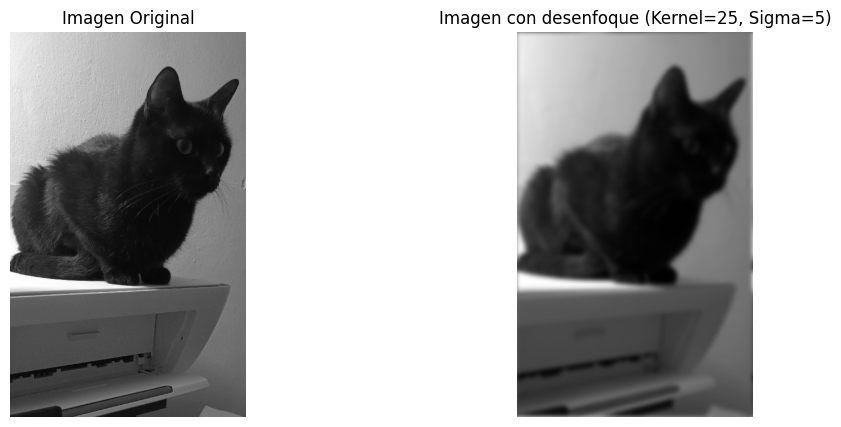

In [8]:
image_path = 'churo.png'
k_sizes = [5, 10, 15, 20, 25]  # Tamaños de kernel
sigmas = [1, 2, 3, 4, 5]  # Valores de sigma

# Mostrar las imagenes originales y con desenfoque
for k_size in k_sizes:
    for sigma in sigmas:
        plot_original_and_filtered(image_path, k_size, sigma)


2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [9]:
def image_quality_measure(img):
    # Step 1: Compute the Fourier Transform representation of the image
    f = np.fft.fft2(img)
    
    # Step 2: Find Fc which is obtained by shifting the origin of F to the center
    fc = np.fft.fftshift(f)
    
    # Step 3: Calculate AF = abs(Fc)
    af = np.abs(fc)
    
    # Step 4: Calculate M = max(AF)
    M = np.max(af)
    
    # Step 5: Calculate thres = M/1000
    thres = M / 1000.0
    
    # Step 6: Calculate TH, the total number of pixels in F whose pixel value > thres
    TH = np.sum(af > thres)
    
    # Calculate Image Quality Measure (FM)
    M, N = img.shape
    FM = TH / (M * N)
    
    return FM


In [10]:
def create_conv_gaussian_kernel(kernel_size, sigma):
    kernel = cv.getGaussianKernel(kernel_size, sigma)
    kernel = kernel @ kernel.T  # Obtener el producto externo para obtener una matriz 2D
    return kernel

In [11]:
def apply_gaussian_filter(image, kernel):
    result = cv.filter2D(image, -1, kernel)
    return result

In [12]:
def quality_measure_based_std_dev_espectral(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, kernel_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = image_quality_measure(imagen_blurred)
    return quality_measure    

In [13]:
def quality_measure_based_std_dev_conv(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(kernel_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = image_quality_measure(imagen_blurred)
    return quality_measure 

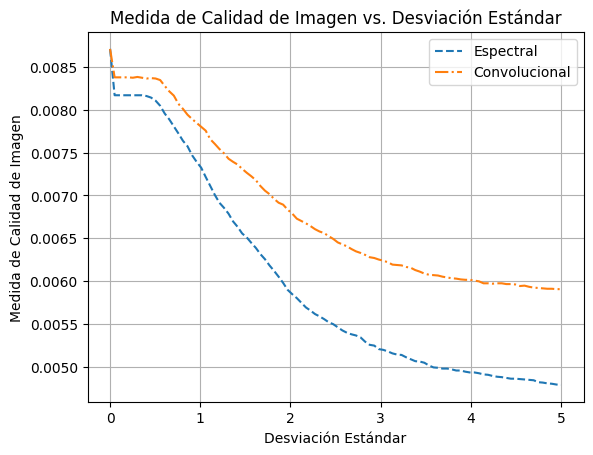

In [14]:
# Generar datos para la desviación estándar
std_dev_values = np.linspace(0, 5, 100)

# Calcular la quality measure para cada desviación estándar
quality_values_espectral_std = [quality_measure_based_std_dev_espectral(std_dev) for std_dev in std_dev_values]
quality_values_conv_std = [quality_measure_based_std_dev_conv(std_dev) for std_dev in std_dev_values]

plt.plot(std_dev_values, quality_values_espectral_std, label='Espectral', linestyle='--')
plt.plot(std_dev_values, quality_values_conv_std, label='Convolucional', linestyle='-.')
plt.xlabel('Desviación Estándar')
plt.ylabel('Medida de Calidad de Imagen')
plt.title('Medida de Calidad de Imagen vs. Desviación Estándar')
plt.legend()
plt.grid(True)
plt.show()


Se observa que la calidad de la imagen disminuye al aumentar el valor de la desviacion estandar para los dos casos, sin embargo, para un mismo tamaño de kernel(si se mantiene constante), el filtrado espectral es mas sensible a la desviacion estandar que el convolucional.

In [15]:
def quality_measure_based_kernel_size_espectral(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    std_dev = 3
    if k_size == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = image_quality_measure(imagen_blurred)
    return quality_measure  

In [16]:
def quality_measure_based_kernel_size_conv(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    std_dev = 3
    if k_size == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(k_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = image_quality_measure(imagen_blurred)
    return quality_measure

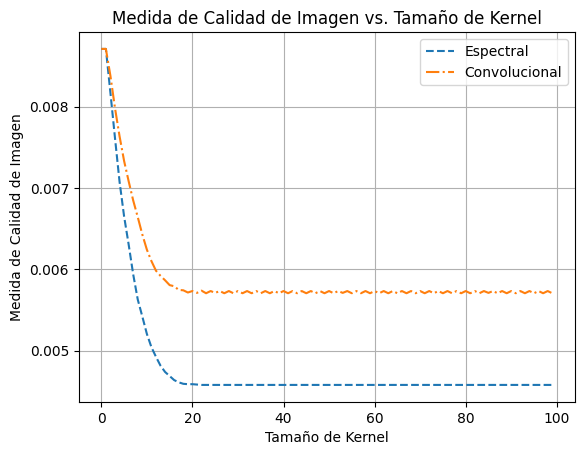

In [17]:
# Generar datos para el tamano de kernel
kernel_values = range(100)
# Calcular la quality measure para cada kernel
quality_values_espectral_kernel = [quality_measure_based_kernel_size_espectral(kernel_size) for kernel_size in kernel_values]
quality_values_conv_kernel = [quality_measure_based_kernel_size_conv(kernel_size) for kernel_size in kernel_values]

plt.plot(kernel_values, quality_values_espectral_kernel, label='Espectral', linestyle='--')
plt.plot(kernel_values, quality_values_conv_kernel, label='Convolucional', linestyle='-.')
plt.xlabel('Tamaño de Kernel')
plt.ylabel('Medida de Calidad de Imagen')
plt.title('Medida de Calidad de Imagen vs. Tamaño de Kernel')
plt.legend()
plt.grid(True)
plt.show()

Se observa que la calidad de la imagen disminuye al aumentar el valor del tamaño del kernel para los dos casos, sin embargo, para una misma desviacion estandar de kernel, el filtrado espectral se ve mas sensible al tamaño del Kernel que el convolucional.

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”.

In [18]:
# TENENGRAD

def tenengrad_focus_measure(image):

    # Calcular el gradiente usando Sobel operators
    gradient_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=1)
    gradient_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=1)

    # Calcular la energia como la suma de los cuadrados de los gradientes
    energy = np.sum(gradient_x**2 + gradient_y**2)

    return energy


In [19]:
def tenengrad_based_std_dev_espectral(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, kernel_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = tenengrad_focus_measure(imagen_blurred)
    return quality_measure 

In [20]:
def tenengrad_based_std_dev_conv(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(kernel_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = tenengrad_focus_measure(imagen_blurred)
    return quality_measure

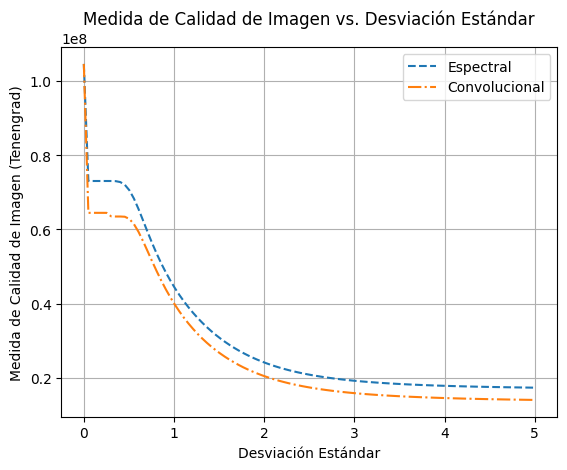

In [21]:
# Generar datos para la desviación estándar
std_dev_values = np.linspace(0, 5, 100)

# Calcular la quality measure para cada desviación estándar
tenengrad_values_espectral_std = [tenengrad_based_std_dev_espectral(std_dev) for std_dev in std_dev_values]
tenengrad_values_conv_std = [tenengrad_based_std_dev_conv(std_dev) for std_dev in std_dev_values]

plt.plot(std_dev_values, tenengrad_values_espectral_std, label='Espectral', linestyle='--')
plt.plot(std_dev_values, tenengrad_values_conv_std, label='Convolucional', linestyle='-.')
plt.xlabel('Desviación Estándar')
plt.ylabel('Medida de Calidad de Imagen (Tenengrad)')
plt.title('Medida de Calidad de Imagen vs. Desviación Estándar')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def tenengrad_based_kernel_size_espectral(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    std_dev = 3
    if k_size == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = tenengrad_focus_measure(imagen_blurred)
    return quality_measure  

In [23]:
def tenengrad_based_kernel_size_conv(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    std_dev = 10
    if k_size == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(k_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = tenengrad_focus_measure(imagen_blurred)
    return quality_measure

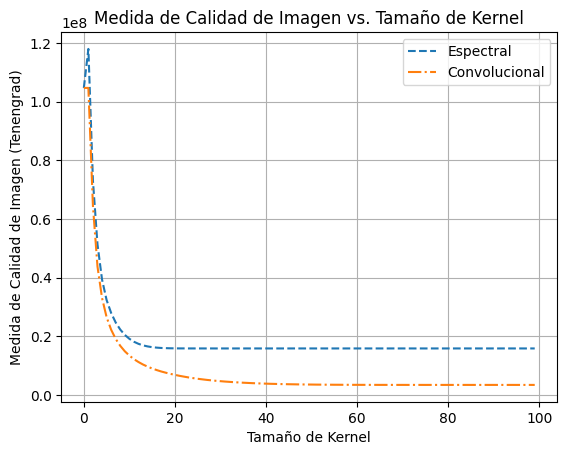

In [24]:
# Generar datos para el tamano de kernel
kernel_values = range(100)
# Calcular la quality measure para cada kernel
tenengrad_values_espectral_kernel = [tenengrad_based_kernel_size_espectral(kernel_size) for kernel_size in kernel_values]
tenengrad_values_conv_kernel = [tenengrad_based_kernel_size_conv(kernel_size) for kernel_size in kernel_values]

plt.plot(kernel_values, tenengrad_values_espectral_kernel, label='Espectral', linestyle='--')
plt.plot(kernel_values, tenengrad_values_conv_kernel, label='Convolucional', linestyle='-.')
plt.xlabel('Tamaño de Kernel')
plt.ylabel('Medida de Calidad de Imagen (Tenengrad)')
plt.title('Medida de Calidad de Imagen vs. Tamaño de Kernel')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
#ENERGY OF LAPLACIAN
def laplacian_energy(image):
    # Convertir la imagen a grayscale si es imagen a color
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image

    # Calcular el Laplaciano
    laplacian = cv.Laplacian(gray, cv.CV_64F)

    # Calcular la energia del laplaciano como la suma de los valores al cuadrado
    energy = np.sum(laplacian**2)

    return energy

In [26]:
def laplacian_based_std_dev_espectral(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, kernel_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = laplacian_energy(imagen_blurred)
    return quality_measure

In [27]:
def laplacian_based_std_dev_conv(std_dev):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    kernel_size = 10
    if std_dev == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(kernel_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = laplacian_energy(imagen_blurred)
    return quality_measure

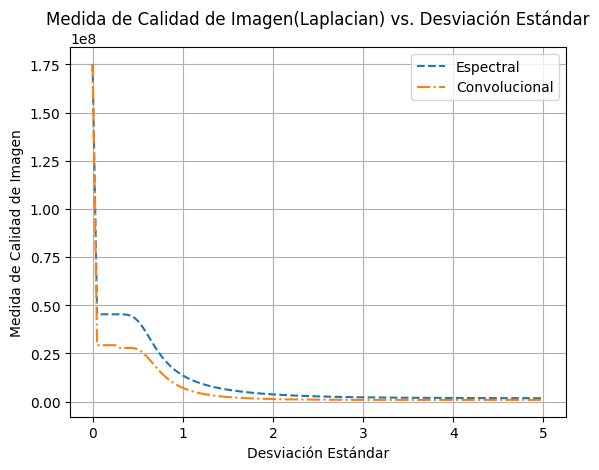

In [28]:
# Generar datos para la desviación estándar
std_dev_values = np.linspace(0, 5, 100)

# Calcular la quality measure para cada desviación estándar
laplacian_values_espectral_std = [laplacian_based_std_dev_espectral(std_dev) for std_dev in std_dev_values]
laplacian_values_conv_std = [laplacian_based_std_dev_conv(std_dev) for std_dev in std_dev_values]

plt.plot(std_dev_values, laplacian_values_espectral_std, label='Espectral', linestyle='--')
plt.plot(std_dev_values, laplacian_values_conv_std, label='Convolucional', linestyle='-.')
plt.xlabel('Desviación Estándar')
plt.ylabel('Medida de Calidad de Imagen')
plt.title('Medida de Calidad de Imagen(Laplacian) vs. Desviación Estándar')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def laplacian_based_kernel_size_espectral(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    altura = imagen.shape[0]
    ancho = imagen.shape[1]
    h, w = altura, ancho
    std_dev = 3
    if k_size == 0:
        imagen_blurred = imagen
    else:
        gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, std_dev)
        imagen_blurred = apply_filter(imagen, fft_gauss_filter)
    quality_measure = laplacian_energy(imagen_blurred)
    return quality_measure  

In [30]:
def laplacian_based_kernel_size_conv(k_size):
    imagen = cv.imread('churo.png', cv.IMREAD_GRAYSCALE)
    std_dev = 10
    if k_size == 0:
        imagen_blurred = imagen
    else:
        kernel = create_conv_gaussian_kernel(k_size, std_dev)
        imagen_blurred = apply_gaussian_filter(imagen, kernel)
    quality_measure = laplacian_energy(imagen_blurred)
    return quality_measure

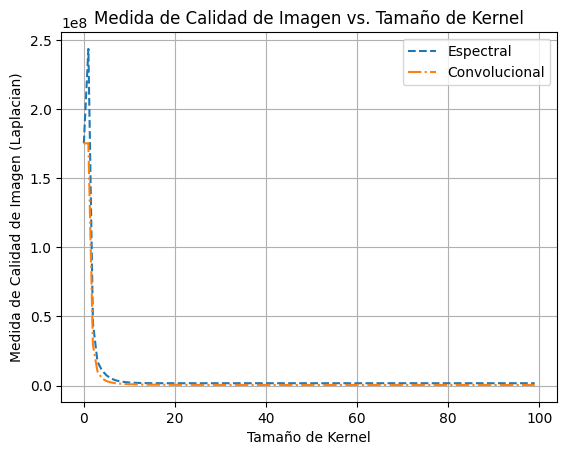

In [31]:
# Generar datos para el tamano de kernel
kernel_values = range(100)
# Calcular la quality measure para cada kernel
laplacian_values_espectral_kernel = [laplacian_based_kernel_size_espectral(kernel_size) for kernel_size in kernel_values]
laplacian_values_conv_kernel = [laplacian_based_kernel_size_conv(kernel_size) for kernel_size in kernel_values]

plt.plot(kernel_values, laplacian_values_espectral_kernel, label='Espectral', linestyle='--')
plt.plot(kernel_values, laplacian_values_conv_kernel, label='Convolucional', linestyle='-.')
plt.xlabel('Tamaño de Kernel')
plt.ylabel('Medida de Calidad de Imagen (Laplacian)')
plt.title('Medida de Calidad de Imagen vs. Tamaño de Kernel')
plt.legend()
plt.grid(True)
plt.show()

Se observa que en el caso de Tenengrad y energia laplaciana, el comportamiento de la filtrado espectral y convolucional presentan comportamientos un poco mas aproximados y se observa las mismas tendencias. A mayor desviacion estandar disminuye la calidad de la imagen y a mayor tamaño de kernel tambien disminuye la calidad de la imagen.